### Notebook version of slabspec_convol so I can play with it

In [1]:
import numpy as np
import urllib
import pandas as pd

import sys

from astropy.table import Table
from astropy import units as un
from astropy.io import fits
from astropy.constants import c,h, k_B, G, M_sun, au, pc, u
from astropy.convolution import Gaussian1DKernel, convolve

import sys
sys.path.append('/Users/jpw/G/py/spectools_ir/')
from spectools_ir.utils import _check_hitran
from spectools_ir.utils import fwhm_to_sigma, sigma_to_fwhm, compute_thermal_velocity, extract_hitran_data
from spectools_ir.utils import  get_molecule_identifier, get_global_identifier, spec_convol, extract_hitran_from_par
from spectools_ir.slabspec.slabspec import _compute_partition_function
from spectools_ir.slabspec.helpers import _strip_superfluous_hitran_data, _convert_quantum_strings

%matplotlib widget

In [2]:
molecule_name = 'CO'
isotopologue_number = 1
n_col = 1e22
temp = 1000
au = 1.5e11
area = (0.3*au)**2

wmin=4.58
wmax=5.2
d_pc=140
res=1e-5
vup=1

In [3]:
si2jy = 1e26
database =_check_hitran(molecule_name)
deltav = compute_thermal_velocity(molecule_name, temp)    # m/s
hitran_data = extract_hitran_data(molecule_name, wmin, wmax, isotopologue_number=isotopologue_number, eupmax=None, aupmin=None, swmin=None, vup=vup)

In [4]:
hitran_data[0:5]

molec_id,local_iso_id,wn,sw,a,gamma_air,gamma_self,elower,n_air,delta_air,Vp,Vpp,Qp,Qpp,ierr1,ierr2,ierr3,ierr4,ierr5,ierr6,iref1,iref2,iref3,iref4,iref5,iref6,line_mixing_flag,gp,gpp,nu,eup_k,wave
int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,bytes15,bytes15,bytes15,bytes15,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,bytes1,float32,float32,float32,float32,float32
5,1,1927.2478,3.21e-27,12.96,0.037,0.039,4306.1377,0.67,-0.002837,1,0,,P 47,4,7,5,6,2,3,5,10,5,5,1,8,,93.0,95.0,57777435000000.0,8968.45,5.1887465
5,1,1932.545,7.487e-27,13.05,0.0374,0.04,4127.954,0.67,-0.002833,1,0,,P 46,4,7,5,6,2,3,5,10,5,5,1,8,,91.0,93.0,57936244000000.0,8719.705,5.174524
5,1,1937.814,1.714e-26,13.16,0.0378,0.04,3953.4575,0.67,-0.002829,1,0,,P 45,4,7,5,6,2,3,5,10,5,5,1,8,,89.0,91.0,58094200000000.0,8476.224,5.1604543
5,1,1943.0544,3.853e-26,13.26,0.0382,0.04,3782.6545,0.67,-0.002826,1,0,,P 44,4,7,5,6,2,3,5,10,5,5,1,8,,87.0,89.0,58251308000000.0,8238.017,5.1465364
5,1,1948.2662,8.502e-26,13.37,0.0386,0.041,3615.552,0.67,-0.002822,1,0,,P 43,4,7,5,6,2,3,5,10,5,5,1,8,,85.0,87.0,58407554000000.0,8005.093,5.1327686


In [5]:
wn0 = hitran_data['wn'] * 1e2        # now m-1
aup = hitran_data['a']
eup = (hitran_data['elower'] + hitran_data['wn']) * 1e2    # now m-1                                                             
gup = hitran_data['gp']
q = _compute_partition_function(molecule_name,temp, isotopologue_number)

Reading partition function from:  https://hitran.org/data/Q/q26.txt


In [6]:
afactor = ((aup * gup * n_col)/(8. * np.pi * q *(wn0)**3))   # mks                                                                 
efactor = h.value * c.value * eup / (k_B.value * temp)       # E/kT
wnfactor = h.value * c.value * wn0 / (k_B.value * temp)      # hnu/kT
phia = 1. / (deltav * np.sqrt(2.0*np.pi))
efactor2 = hitran_data['eup_k'] / temp
efactor1 = hitran_data['elower'] * 1.e2 * h.value * c.value / (k_B.value * temp)
tau0 = afactor * (np.exp(-efactor1) - np.exp(-efactor2)) * phia      # Avoids numerical issues at low T
w0 = 1e6 / wn0

In [7]:
omega = area / (d_pc * pc.value)**2
fthin = aup * gup * n_col * h.value * c.value * wn0 / (4 * np.pi * q) * np.exp(-efactor) * omega    # Energy/area/time, mks  

In [8]:
# velocity range -200 to 200 km/s
dvel = 0.1    # km/s
nvel = 2001
vel = (np.arange(0, nvel) - nvel//2) * dvel   # km/s
vel *= 1000                                   # m/s since all the rest is MKS

In [9]:
# convolution function
sigma = 10  # km/s
v0 = 15
sigma *= 1000    # m/s
v0 *= 1000
phi = np.exp(-(vel-v0)**2 / (2*sigma**2)) + np.exp(-(vel+v0)**2 / (2*sigma**2))
phi /= np.sum(phi)

     P 27      


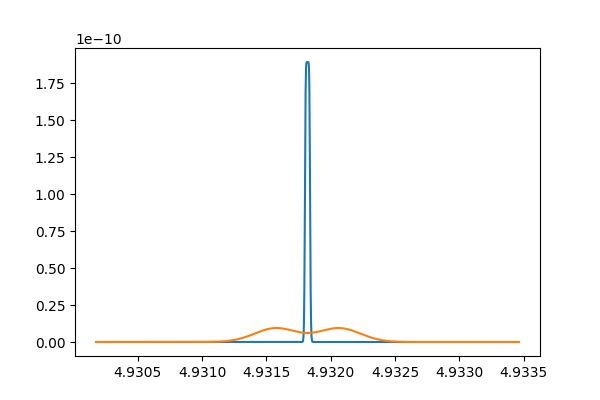

In [10]:
# check to make sure the convolution works as expected
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
R = 30000

nlines = np.size(hitran_data)
#for i, tau1 in eumerate(tau0):
for i in [20]:
    print(hitran_data[i]['Qpp'])
    wave0 = 1e6 / wn0[i]
    tau0v = tau0[i] * np.exp(-vel**2 / (2 * deltav**2))
    Intens = 2 * h.value * c.value * wn0[i]**3 / (np.exp(wnfactor[i]) - 1) * (1 - np.exp(-tau0v))
    Intens_convol = convolve(Intens, phi)
    wave = wave0 * (1 + vel / c.value)
    ax.plot(wave, Intens)
    ax.plot(wave, Intens_convol)
    ax.set_xlim(wave0*(1-11/R), wave0*(1+11/R))

In [11]:
nbins = int((wmax - wmin) / res)
totalwave = wmin + (wmax - wmin) * np.arange(nbins) / nbins
totalflux = np.zeros(nbins)
totalflux_convol = np.zeros(nbins)

nlines = np.size(hitran_data)
for i in np.arange(nlines):
    wave0 = 1e6 / wn0[i]
    tau0v = tau0[i] * np.exp(-vel**2 / (2 * deltav**2))
    Intens = 2 * h.value * c.value * wn0[i]**3 / (np.exp(wnfactor[i]) - 1) * (1 - np.exp(-tau0v))
    Intens_convol = convolve(Intens, phi)
    wave = wave0 * (1 + vel / c.value)
    totalflux += np.interp(totalwave, wave, Intens)
    totalflux_convol += np.interp(totalwave, wave, Intens_convol)

totalflux *= omega * si2jy
totalflux_convol *= omega * si2jy

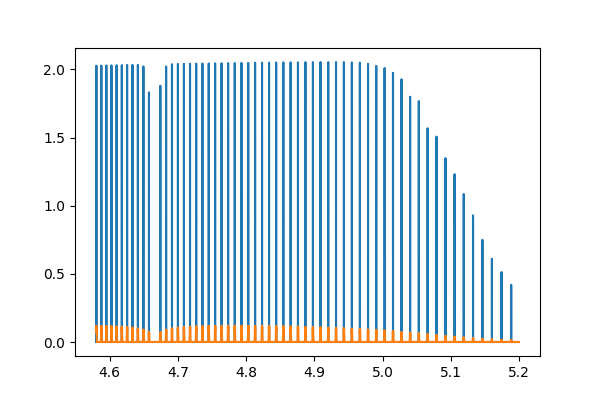

In [12]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
ax.plot(totalwave, totalflux)
ax.plot(totalwave, totalflux_convol)